In [140]:
import torch
t = torch
from torch import nn, optim
import w1d4_tests
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from torchvision import transforms
import einops
from tqdm.notebook import tqdm
import math
import gin
gin.enter_interactive_mode()

In [141]:
# https://www.motorbiscuit.com/wp-content/uploads/2021/09/Drive-through-Redwood-tree.jpg
fname = "/home/ubuntu/mlab/days/w1d4/picture.jpeg"

In [151]:
# w1d4_tests.plot_image(fname)
data_train, data_test = w1d4_tests.load_image(fname)
# print(data_train.dataset['tensors'].__dict__)

@gin.configurable
class OurModule(t.nn.Module):

    def __init__(self, P, H, K):
        super().__init__()

        self.seq = t.nn.Sequential(
            t.nn.Linear(P,H),
            t.nn.ReLU(),
            t.nn.Linear(H,H),
            t.nn.ReLU(),
            t.nn.Linear(H,K),
        )

    def forward(self, x):
        return self.seq(x)



w1d4_tests.test_mlp(OurModule)



Congrats! You've passed the test.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


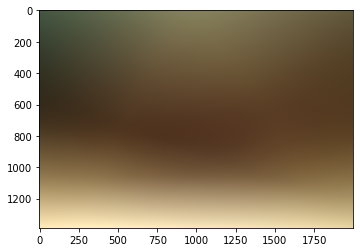

In [152]:

def loss_fn(predicted, target):
    return t.mean(t.abs(target - predicted))

@gin.configurable
def train(model, dataloader, lr, momentum, optimizer, epochs=1):
    if optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    if optimizer == 'rmsprop':
        optimizer = JankRMSProp(model.parameters(), lr=lr, momentum=momentum)
    if optimizer == 'adam':
        pass
    for epoch in range(epochs):
        for input, target in dataloader:
            optimizer.zero_grad()    # sets param.grad to None for linked params
                                    # (this prevents accumulation of gradients)
            output = model(input)          # the model’s predictions
            loss = loss_fn(output, target)      # measure how bad predictions are
            loss.backward()              # calculate gradients
            optimizer.step()              # use gradients to update params
    return model



if __name__ == "__main__":
    with gin.unlock_config():
        gin.parse_config_file(config_file = "config.gin")
        m = OurModule(P=2, K=3)
        train(model=m, dataloader=data_train)
        print_picture(m, fname)
# w1d4_tests.test_train(train)

In [135]:
def evaluate(model, dataloader):
    total_loss = 0
    for input, target in dataloader:
        # print(target)
        output = model(input)
        loss = loss_fn(output, target)
        total_loss += loss*input.size(dim=0)
    return total_loss/len(dataloader.dataset)

w1d4_tests.test_evaluate(evaluate)

Congrats! You've passed the test.


In [ ]:
model = OurModule(2, 400, 3)    # this is a nn.Module
# # optimizer represents the algorithm we use for updating parameters
test_losses = []
for epoch in tqdm(range(50)):
    train(model, data_train, 0.01, 0.9)
    test_loss = evaluate(model, data_test)
    test_losses.append(test_loss)

plt.plot(test_losses)


In [148]:
def print_picture(model, fname):
    img = Image.open(fname)
    tensorize = transforms.ToTensor()
    img = tensorize(img)
    c, h, w = img.size()

    t_img = t.zeros(h, w, 2)
    t_img[...,0] = einops.rearrange(t.linspace(-.5, .5, h), 'h -> h 1')
    t_img[...,1] = einops.rearrange(t.linspace(-.5, .5, w), 'w -> 1 w')
    # print(t_img)
    new_img = model(t_img)
    matplotlib.pyplot.imshow((new_img + 0.5).detach().numpy())
# print(new_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


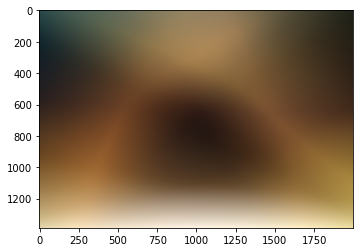

In [95]:
def banana(x, y, a=1, b=100):
    return (a-x)**2 + b*(y-x**2)**2 + 1
def tuple_log_banana(xy):
    return math.log(banana(*xy))

def plot_banana():
    n_values = 100
    t_img = t.zeros(n_values, n_values, 2)
    t_img[...,0] = einops.rearrange(t.linspace(-2, 2, n_values), 'h -> h 1')
    t_img[...,1] = einops.rearrange(t.linspace(-1, 3, n_values), 'w -> 1 w')


    plt.contourf(t_img[...,0], t_img[...,1],
        t.tensor(list(map(tuple_log_banana, t_img.reshape(-1,2)))).reshape(n_values, n_values))


Testing configuration:  {'lr': 0.001, 'momentum': 0.0, 'n_iter': 10}
Your module returns different results from the example solution.

Testing configuration:  {'lr': 0.001, 'momentum': 0.8, 'n_iter': 20}
Your module returns different results from the example solution.


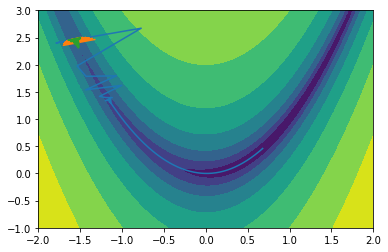

In [112]:
def opt_rosenbrock(xy, lr, momentum, n_iter, optimizer=None):
    if optimizer is None:
        optimizer = optim.SGD([xy], lr=lr, momentum=momentum)
    points = [torch.clone(xy)]
    for e in range(n_iter):
        # print(xy)
        optimizer.zero_grad()
        loss = banana(*xy)
        loss.backward()
        optimizer.step()
        points.append(torch.clone(xy))
    plt.plot([p[0] for p in points], [p[1] for p in points])
    return xy
plot_banana()
w = t.Tensor([-1.5, 2.5])
w.requires_grad = True
opt_rosenbrock(w, 0.002, 0.5, 500)
w1d4_tests.test_rosenbrock(opt_rosenbrock)


In [101]:
class JankSGD:
    def __init__(self, params, lr=0.001, momentum=0, dampening=0, weight_decay=0):
        self.params = list(params)
        if momentum > 0:
            self.b = [None for _ in range(len(self.params))]
        self.lr = lr
        self.momentum = momentum
        self.dampening = dampening
        self.weight_decay = weight_decay

    def zero_grad(self):
        for p in self.params:
            p.grad = None

    def step(self):
        with torch.no_grad():
            for i,p in enumerate(self.params):
                g = p.grad
                if self.weight_decay != 0:
                    g += self.weight_decay*p
                if self.momentum != 0:
                    if self.b[i] is None:
                        self.b[i] = g
                    else:
                        self.b[i] = self.momentum*self.b[i] + (1-self.dampening)*g
                        g = self.b[i]     
                p -= self.lr*g
    
w1d4_tests.test_sgd(JankSGD)


Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'dampening': 0.0, 'weight_decay': 0.05}
Congrats! You've passed the test.


In [106]:
@gin.configurable
class JankRMSProp:
    def __init__(self, params, lr, alpha, eps, weight_decay, momentum):
        self.params = list(params)
        self.lr = lr
        self.v = [0 for _ in range(len(self.params))]
        self.momentum = momentum
        if self.momentum > 0:
            self.b = [0 for _ in range(len(self.params))]
        self.alpha = alpha
        self.eps = eps
        self.weight_decay = weight_decay
    
    def zero_grad(self):
        for p in self.params:
            p.grad = None
        
    
    def step(self):
        with torch.no_grad():
            for i,p in enumerate(self.params):
                g = p.grad
                if self.weight_decay != 0:
                    print(self.weight_decay)
                    print(self.weight_decay)
                    g = g + self.weight_decay*p
                self.v[i] = self.alpha*self.v[i] + (1-self.alpha)*g*g
                # centered = false
                if self.momentum > 0:
                    self.b[i] = self.momentum*self.b[i] + g/(t.sqrt(self.v[i]) + self.eps)
                    p -= self.lr*self.b[i]
                else:
                    p -= self.lr*g/(t.sqrt(self.v[i]) + self.eps)

w1d4_tests.test_rmsprop(JankRMSProp)



Testing configuration:  {'lr': 0.1, 'alpha': 0.9, 'eps': 0.001, 'weight_decay': 0.0, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.5}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.


In [110]:
class JankAdam:
    def __init__(self, params, lr, betas, eps, weight_decay):
        self.params = list(params)
        self.lr = lr
        self.v = [0 for _ in range(len(self.params))]
        self.b1, self.b2 = betas
        self.m = [0 for _ in range(len(self.params))]
        self.eps = eps
        self.weight_decay = weight_decay
        self.t = 0
    
    def zero_grad(self):
        for p in self.params:
            p.grad = None
        
    
    def step(self):
        self.t += 1
        with torch.no_grad():
            for i,p in enumerate(self.params):
                g = p.grad
                if self.weight_decay != 0:
                    g = g + self.weight_decay*p
                self.m[i] = self.b1*self.m[i] + (1-self.b1)*g
                self.v[i] = self.b2*self.v[i] + (1-self.b2)*g**2
                m_hat = self.m[i]/(1-self.b1**self.t)
                v_hat = self.v[i]/(1-self.b2**self.t)
                p -= self.lr * m_hat/(t.sqrt(v_hat) + self.eps)

w1d4_tests.test_adam(JankAdam)




Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
Congrats! You've passed the test.


tensor([-0.2376,  0.0590], requires_grad=True)

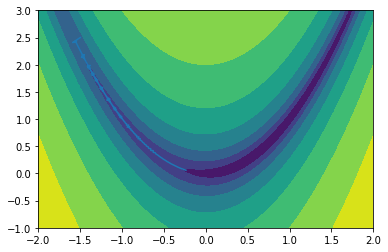

In [126]:
w = t.Tensor([-1.5, 2.5])
w.requires_grad = True
n_iter = 200
lr = 0.02

plot_banana()
opt_rosenbrock(w, lr, .5, n_iter, optimizer=JankRMSProp([w], lr, 0.9, 1e-5, 0.02, .5))

# opt_rosenbrock(w, lr, .5, n_iter, optimizer=JankAdam([w], lr, (0.9, 0.9), 1e-5, 0.02))
# opt_rosenbrock(w, lr, momentum, n_iter, optimizer=)
# opt_rosenbrock(w, lr, momentum, n_iter, optimizer=)